In [1]:
import requests
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
import os
os.environ['http_proxy'] = "http://ptamax01-proxy001.emea.nsn-net.net:8080/" 
os.environ['https_proxy'] = "http://ptamax01-proxy001.emea.nsn-net.net:8080/"                 

## Famous leagues and abbreviations:
* Barclays Premier League: PL
* La Liga Santander: PD
* Bundesliga: BL1
* Liga NOS: PPL
* Ligue 1: FL1
* Serie A: SA

In [17]:
match_master_list=[]
league='FL1' #insert here the chosen abbreviation

for year in range(2018,2020):   
    uri = 'http://api.football-data.org/v2/competitions/'+league+'/matches?season=' + str(year)
    headers = { 'X-Auth-Token': '291d3414a2f641ba9d97102df496e9cd' }
    response = requests.get(uri, headers=headers)      
    match_list=response.json()['matches']
    match_master_list.append(match_list)
    nr_games=len(match_list)
    
    teams_list=[match_list[i]['homeTeam']['name'] for i in range (0, nr_games)]   
           
    if year == 2019:
        teams_list=np.unique(teams_list)
        print("List of teams: " ,teams_list)
        team=input("Team name:")

List of teams:  ['AS Monaco FC' 'AS Saint-Étienne' 'Amiens SC' 'Angers SCO'
 "Dijon Football Côte d'Or" 'FC Girondins de Bordeaux' 'FC Metz'
 'FC Nantes' 'Lille OSC' 'Montpellier HSC' 'Nîmes Olympique' 'OGC Nice'
 'Olympique Lyonnais' 'Olympique de Marseille' 'Paris Saint-Germain FC'
 'RC Strasbourg Alsace' 'Stade Brestois 29' 'Stade Rennais FC 1901'
 'Stade de Reims' 'Toulouse FC']
Team name:Montpellier HSC


In [18]:
team_matches=[]
next_matches=[]
next_home_away=[]
score_list=[]
goals_list=[]
home_away_list=[]
winner=[]
scheduled=1

for j in range (0, len(match_master_list)):
    for i in range (0, nr_games):
    
        if match_master_list[j][i]['homeTeam']['name']==team or match_master_list[j][i]['awayTeam']['name']==team:
            
            if match_master_list[j][i]['status']=='FINISHED':
                game= match_master_list[j][i]['homeTeam']['name']+" vs "+ match_master_list[j][i]['awayTeam']['name']
                
                if (team == game.split(" vs ")[0]):
                    home_away_list.append(1)
                    
                    if(match_master_list[j][i]['score']['winner']=='HOME_TEAM'):
                        winner.append(1)
                    
                    else:
                        winner.append(0)
                
                else:
                    home_away_list.append(0)
                    
                    if(match_master_list[j][i]['score']['winner']=='AWAY_TEAM'):
                        winner.append(1)
                    
                    else:
                        winner.append(0)
                        
                team_matches.append(game)
                result= str(match_master_list[j][i]['score']['fullTime']['homeTeam'])+ " - " + str(match_master_list[j][i]['score']['fullTime']['awayTeam'])
                score_list.append(result)
                goals_list.append(int(match_master_list[j][i]['score']['fullTime']['homeTeam'])+int(match_master_list[j][i]['score']['fullTime']['awayTeam']))
                played=len(team_matches)
                
            if match_master_list[j][i]['status']!='FINISHED':
                game= match_master_list[j][i]['homeTeam']['name']+" vs "+ match_master_list[j][i]['awayTeam']['name']
                
                if (team == game.split(" vs ")[0]):
                    home_away_list.append(1)
                    
                else:
                    home_away_list.append(0)
                    
                team_matches.append(game)
                score_list.append(0)
                goals_list.append(0)
                winner.append(0)

In [19]:
#Calling DataFrame constructor after zipping 
# both lists, with columns specified 
df = pd.DataFrame(list(zip(team_matches, home_away_list, goals_list, winner)), 
               columns =['Match', 'Home/Away', 'Goals', 'Won']) 

labels, uniques = pd.factorize(df.Match)
df['Match']=labels

In [20]:
mode='Won' #Choose to predict which team is going to win (insert Won) or how many goals will the match have (insert Goals)
ngoals=2.5 #The goals threshold, the game will have more or less than ngoals

X=df.filter(['Match', 'Home/Away'], axis=1)[:played]
y=df[mode][:played]
next_game=df.filter(['Match', 'Home/Away'], axis=1)[played:]

if mode=='Goals':
    y=[1 if i>ngoals else 0 for i in y]

def convert_divide(dataframe, df_format,split):
    """
    Converts a pandas dataframe to matrix or array and splits it into training and test set 
    according to the input percentage.
    Args:
        dataframe: the input dataframe to split
        df_format: 'Matrix' if the dataframe is to be converted into a matrix
                   'Array' if the dataframe is to be converted into an array
        split: The split percentage to split the dataframe into training and test sets
    Returns: Training and test sets properly splitted
    """
    
    div=int(len(X)*split*0.01)
    dataframe = np.matrix(dataframe) if df_format == 'Matrix' else np.array(dataframe)    
    df_train=dataframe[:div]
    df_test=dataframe[div:]
    return df_train, df_test

X_train, X_test = convert_divide(X, 'Matrix', 80)
y_train, y_test = convert_divide(y, 'Array', 80)
next_game=np.matrix(next_game)

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
next_game_matrix=xgb.DMatrix(next_game[0])

param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.01,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic',  # error evaluation for multiclass training
    'eval_metric' : 'logloss'
}

num_round = 100 # the number of training iterations

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)
print(preds)

print ("Accuracy:", accuracy_score(y_test, preds.round()))

[0.4252089  0.4262876  0.56076944 0.4262876  0.4850299  0.31968567
 0.56076944 0.31968567 0.4850299  0.42521676 0.42521676 0.31968567]
Accuracy: 0.5833333333333334


In [22]:
if (mode=='Goals'):
    print('The next match has a probability of: ', bst.predict(next_game_matrix)[0]*100, '% to have more than', ngoals, 'goals.')
else:
    print(team, 'has a probability of: ', bst.predict(next_game_matrix)[0]*100, '% to win the next match.')
    print("Bet on " , team,  "to win with an odd of: ", (1-final_accuracy)*4 )

Montpellier HSC has a probability of:  48.50299060344696 % to win the next match.


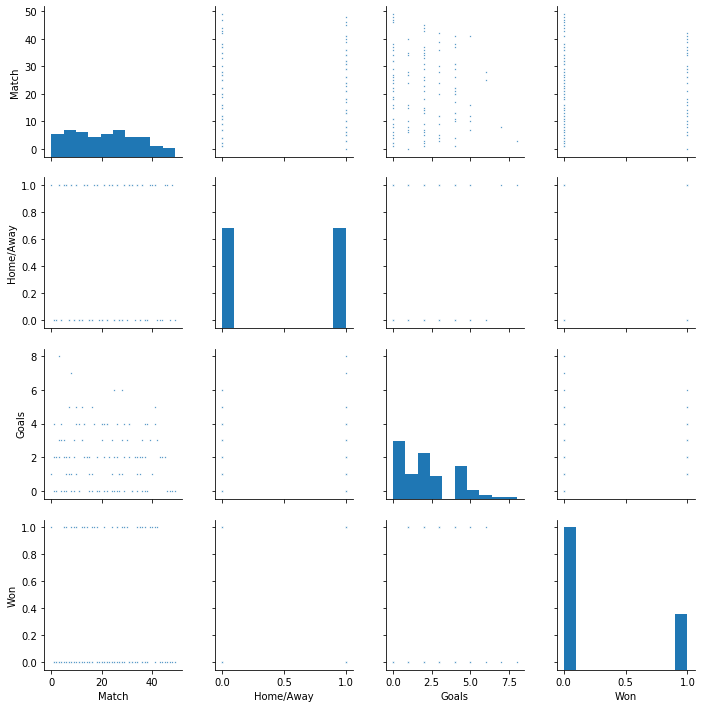

In [202]:
import seaborn as sns

g = sns.pairplot(df, 
                 diag_kind='hist',  # histogram plot for diag
                 dropna=True,
                 palette=sns.color_palette(['red', 'green']), # # yes is green and no is red
                 plot_kws={
                     's':3 # size of the point
                 },
                 
                )